# Week 7 - Temporal models 

## Part 4: Road traffic - Time-series imputation (with multivariate LDS)

In this part, we will specify a **multivariate** linear dynamical system (LDS) in Pyro in order to do **imputation** on the freeway occupancy rates. The intuition is rather simple:
- Based on our domain knowledge and our knowledge about the problem, we know that freeway occupancy rates at nearby road segments should be highly correlated (cars don't just disappear; the must go somewhere!). Therefore, time-series observations from nearby sensors should also reflect these correlations.
- We can thus exploit these correlations and use the related time-series from nearby sensors (which probably will itself have missing observations) in order to help us do imputation on the time-series from a given sensor.

In this notebook, we will **use a multivariate LDS in order to explore these correlations and try to improve our imputations**.

The usual imports...

In [0]:
!pip install numpyro

     |████████████████████████████████| 163kB 2.8MB/s 
     |████████████████████████████████| 25.4MB 2.1MB/s 
     |████████████████████████████████| 256kB 46.4MB/s 
  Created wheel for jax: filename=jax-0.1.57-cp36-none-any.whl size=297709 sha256=8d74f95ad224816fb9c455e76f9a27b234504f6c966f90b98fd9a4ab222704bd
  Stored in directory: /root/.cache/pip/wheels/8a/b4/75/859bcdaf181569124306615bd9b68c747725c60bfa68826378
  Created wheel for fastcache: filename=fastcache-1.1.0-cp36-cp36m-linux_x86_64.whl size=39201 sha256=fcbb8a4c811b5e48a4b6fe7c8e722558037665e1919f468d69bb3aef04eda1d3
  Stored in directory: /root/.cache/pip/wheels/6a/80/bf/30024738b03fa5aa521e2a2ac952a8d77d0c65e68d92bcd3b6
Successfully built jax fastcache
  Found existing installation: jaxlib 0.1.38
    Uninstalling jaxlib-0.1.38:
      Successfully uninstalled jaxlib-0.1.38
  Found existing installation: jax 0.1.58
    Uninstalling jax-0.1.58:
      Successfully uninstalled jax-0.1.58


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

The data consists of time-series of freeway occupancy rates (rows), with length $T=1008$, at 10 different consecutive sensors/detectors (columns). Although we will focus only on the data from two specific detectors as an example...

Load data:

In [0]:
# load csv
df = pd.read_csv("https://raw.githubusercontent.com/Chechgm/42186-model-based-machine-learning/master/Notebooks/Week%207/PeMS_sample.csv")
df.head()

,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
0,0.0154,0.0054,0.0164,0.0079,0.0059,0.0138,0.0111,0.0156,0.0154,0.0080
1,0.0085,0.0051,0.0127,0.0062,0.0051,0.0125,0.0099,0.0175,0.0134,0.0067
2,0.0099,0.0056,0.0172,0.0068,0.0053,0.0116,0.0105,0.0157,0.0112,0.0065
3,0.0108,0.0045,0.0126,0.0072,0.0058,0.0131,0.0073,0.0146,0.0128,0.0040
4,0.0100,0.0037,0.0185,0.0048,0.0063,0.0099,0.0061,0.0157,0.0123,0.0064


Some basic data statistics:

In [0]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 1008
General statistics:


,# detector400000,detector400001,detector400009,detector400010,detector400015,detector400017,detector400025,detector400026,detector400027,detector400030
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1008.00000,1008.000000
mean,0.049489,0.044541,0.066207,0.051599,0.026812,0.047976,0.037051,0.055881,0.05583,0.049262
std,0.030016,0.047490,0.047321,0.040934,0.019402,0.052455,0.036248,0.049275,0.04192,0.042152
min,0.005300,0.000000,0.000000,0.000000,0.001900,0.002200,0.002900,0.002500,0.00150,0.001500
25%,0.027150,0.014900,0.029525,0.018000,0.013100,0.014775,0.012075,0.017950,0.01820,0.027075
50%,0.055300,0.038600,0.070500,0.046400,0.021700,0.038750,0.029000,0.051500,0.05665,0.046700
75%,0.064400,0.051900,0.088025,0.070800,0.030925,0.054125,0.045400,0.069825,0.07670,0.058925
max,0.317600,0.355000,0.393600,0.232700,0.094900,0.316900,0.197200,0.307400,0.22060,0.408100


Visualize data (part of it):

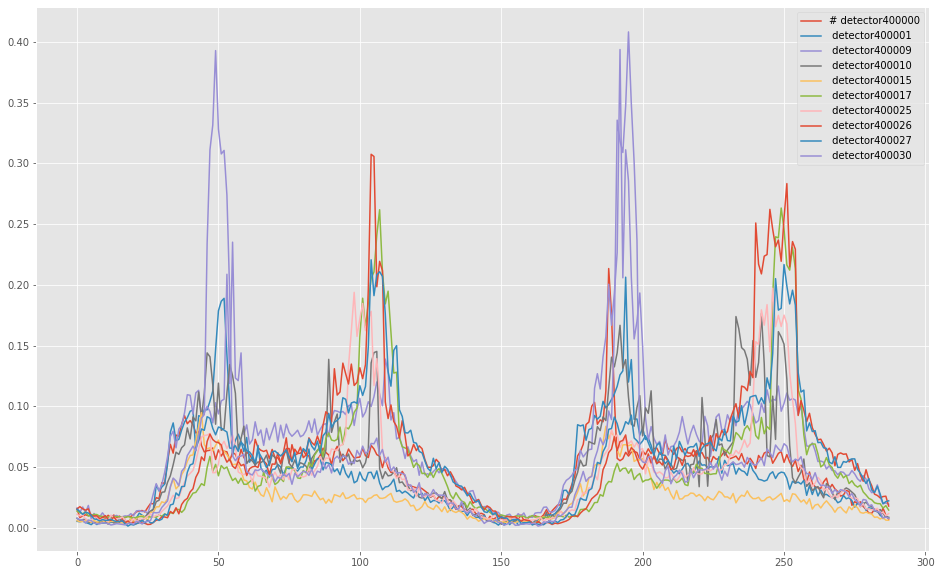

In [0]:
plt.plot(df[:(2*24*6)]); # first 2 days (2*24*6 10-minute intervals) of each of the 10 detectors
plt.legend(df.columns);

Lets now generate some articial missing data at random. To make things challenging, will consider a difficult setting were **80% of the observations are missing**. 

Notice that we save the real observations for the 80% missings, in order to evaluate the accuracy of our imputations later on.

Also, **note that both of the time-series that we will be using in this notebook have 80% of missing observations!**

In [0]:
# convert data to a matrix
y = df.values
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=10


In [0]:
missing_perc = 0.8 # missing percentage

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 29
N_mis: 115


Lets try to implement a multivariate LDS in Pyro! The model will have quite a few similaries with the one from the previous notebook (i.e. part 3), but also some significant changes.


The first thing to notice is that we will now have two time-series instead of one! You therefore should make changes accordingly.


We will model the correlations between the two series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or, if you prefer (equivalent!):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the simple model described above is the **covariance matrix $\boldsymbol\Sigma$**! This the object that will allow us to capture the correlations between the two time-series. We therefore need it to be a full matrix (i.e. rather than a isotropic covariance matrix of the form $\boldsymbol\Sigma = \sigma^2 \textbf{I}$)! Do you understand why?

What about the prior for $\boldsymbol\Sigma$? While the inverse-Wishart distribution is the conjugate prior for the covariance matrix of a multivariate normal distribution, it is not very well-suited to modern Bayesian computational methods. For this reason, the **LKJ prior** is recommended when modeling the covariance matrix of a multivariate normal distribution. More on that in a minute...

In Pyro, the recommended approach is to use a lower triangular representation of the covariance matrix $\boldsymbol\Sigma$. In practice, we will use the `numpyro.distributions.LKJCorrCholesky` ([docs](http://docs.pyro.ai/en/stable/_modules/pyro/distributions/lkj.html)) distribution and combine it with a vector of variances `jnp.diag(jnp.sqrt(tau))`.

\begin{align}
\boldsymbol\Sigma_{lowertriangular} = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

We can define these variables inside our Pyro model. Like any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but we recommend something weakly informative like a half-Cauchy distribution with a small scale, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0)
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, Pyro recommends using a LKJ prior as follows:

- `L_Omega = numpyro.sample("L_Omega", dist.LKJCholesky(d=2, eta=10.))`
- `Sigma_lower = jnp.matmul(jnp.diag(jnp.sqrt(tau)), L_Omega)`,

where `d` represents the dimensionality of the matrix and `eta` parametrizes the distribution.

The intuition behind the LKJ correlation distribution for modeling is that as its parameter `eta` increases, the prior increasingly concentrates around the unit correlation matrix (i.e., favors less correlation among the components of $\textbf{z}$). At `eta=1`, the LKJ correlation distribution reduces to the identity distribution over correlation matrices. The LKJ prior may thus be used to control the expected amount of correlation among the values of $\textbf{z}$.

We define these priors in Pyro as follows:

`tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=jnp.ones(2)))` 

Finally, we can define a multivariate Gaussian for our reparametrization of the noise using:

`noises = numpyro.sample("noises", fn=dist.MultivariateNormal(loc=jnp.zeros(2), scale_tril=Sigma_lower), sample_shape=(T+T_forecast-1,))`

Ok, after this (long) explanation, do you think you can implement in Pyro the multivariate LDS described above? :-)

In [0]:
def f(carry, noise_t):
  beta, z_prev, tau = carry
  z_t = beta*z_prev + noise_t
  z_prev = z_t
  return (beta, z_prev, tau), z_t

In [0]:
from torch.distributions import constraints
import numpy

def model(T, T_forecast, obs1=None, ix_mis1=None, ix_obs1=None, obs2=None, ix_mis2=None, ix_obs2=None):
    """
    Define priors over beta, tau, sigma, z_1 (keep the shapes in mind)
    """
    # Your code here
    
    """
    Define LKJ prior
    """
    # Your code here
    
    """
    Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    # Your code here
    
    """
    Sample the observed y (y_obs) and missing y (y_mis)
    """
    # Your code here

Run inference using MCMC:

In [0]:
t0 = time.time()

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N, T_forecast=0, obs1=y_obs1, ix_mis1=ix_mis1, ix_obs1=ix_obs1, 
         obs2=y_obs2, ix_mis2=ix_mis2, ix_obs2=ix_obs2)

t_fin = time.time()

print("Total time: {0:.3f}m".format((t_fin - t0)/60))

sample: 100%|██████████| 2000/2000 [01:47<00:00, 18.54it/s, 1023 steps of size 5.40e-03. acc. prob=0.76]


Total time: 2.073m


In [0]:
mcmc.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 L_Omega[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
 L_Omega[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
 L_Omega[1,0]      0.29      0.19      0.30      0.02      0.63     62.30      1.02
 L_Omega[1,1]      0.93      0.06      0.95      0.85      1.00     69.51      1.00
      beta[0]      0.97      0.02      0.97      0.95      1.00     93.67      1.00
      beta[1]      0.99      0.01      0.99      0.98      1.00    255.99      1.00
  noises[0,0]      0.00      0.02      0.00     -0.02      0.03    333.24      1.00
  noises[0,1]      0.00      0.01      0.00     -0.01      0.01    670.91      1.00
  noises[1,0]     -0.00      0.02     -0.00     -0.03      0.02    283.88      1.00
  noises[1,1]     -0.00      0.01      0.00     -0.01      0.01    624.05      1.01
  noises[2,0]     -0.00      0.02     -0.00     -0.03      0.02    520.44  

Extract samples and plot posteriors over some of the latent variables (parameters): tau and sigma

In [0]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

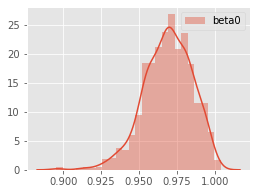

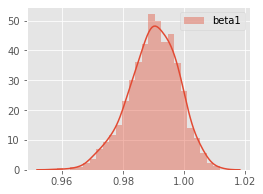

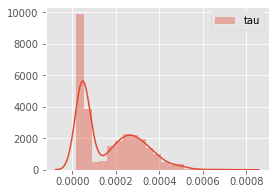

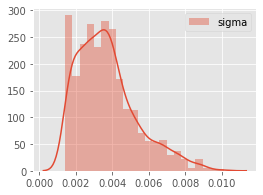

In [0]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
  if node == "beta":
    for i in range(2):
      plt.figure(figsize=(4,3))
      sns.distplot(hmc_samples[node][:,i], label=node+"%d"%i)
      plt.legend()
    plt.show()
  else:
    plt.figure(figsize=(4,3))
    sns.distplot(hmc_samples[node], label=node)
    plt.legend()
    plt.show()

Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [0]:
# get mean and standard devitions for predictions
y_hat = hmc_samples["y_mis1"].mean(axis=0)
y_std = hmc_samples["y_mis1"].std(axis=0)

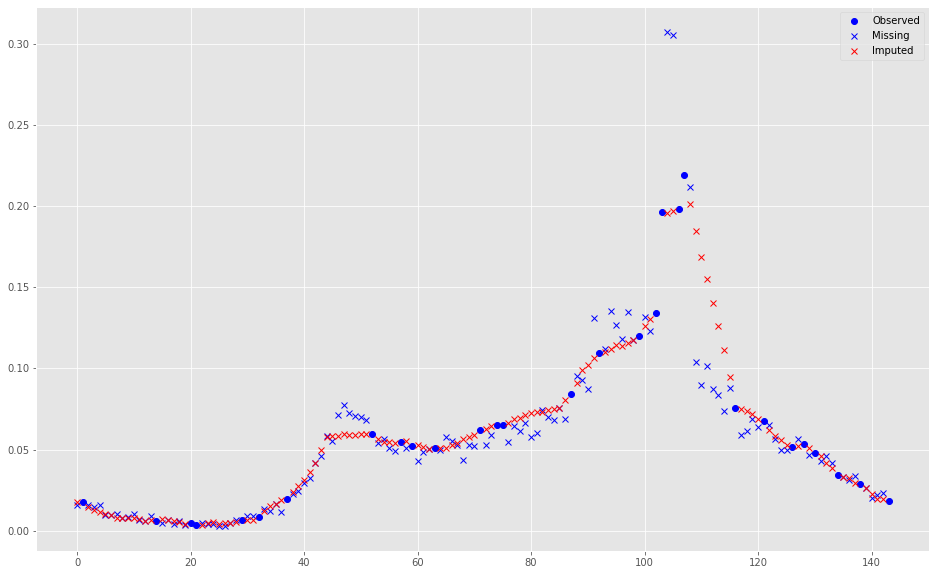

In [0]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
plt.legend(["Observed", "Missing", "Imputed"]);

Compute error statistics of the model's imputations:

In [0]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [0]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.908
MAE: 0.00954
RMSE: 0.02113
R2: 0.824


Did you get a better result than with univariate LDS model from notebook 3? Compare the error statistics and the plots. You should have obtained a better result using the multivariate LDS. We could probably improve these results even further by:
- Consider even more correlated time-series (instead of just 2) and model their correlations in the multivariate LDS;
- Building more complex temporal dynamics, e.g. with higher order dependencies, with high dimensional latent states, different distributions, etc.